In [70]:
# necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

### Calling the dataset

In [71]:
# calling the libraries
df = pd.read_csv("./INR-USD.csv")[:-1]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-01,45.709000,45.728001,45.449001,45.480000,45.480000,0.0
1,2003-12-08,45.474998,45.507999,45.352001,45.451000,45.451000,0.0
2,2003-12-15,45.450001,45.500000,45.332001,45.455002,45.455002,0.0
3,2003-12-22,45.417000,45.549000,45.296001,45.507999,45.507999,0.0
4,2003-12-29,45.439999,45.645000,45.421001,45.560001,45.560001,0.0


### Cleaning Dataset

In [72]:
# keeping only date and adjusted close columns 
df = df[["Date", "Adj Close"]]
df.head()

,Date,Adj Close
0,2003-12-01,45.480000
1,2003-12-08,45.451000
2,2003-12-15,45.455002
3,2003-12-22,45.507999
4,2003-12-29,45.560001


In [73]:
# setting the indices as dates
df = df.set_index("Date")
df.head()

,Adj Close
Date,
2003-12-01,45.480000
2003-12-08,45.451000
2003-12-15,45.455002
2003-12-22,45.507999
2003-12-29,45.560001


In [74]:
# checking for the existence of the null values
df.isna().sum() # there are 3 null values in the adjusted close columns

Adj Close    3
dtype: int64

In [75]:
# handling missing values using backward filling method
df = df.fillna(method="bfill")

### Exploring the data

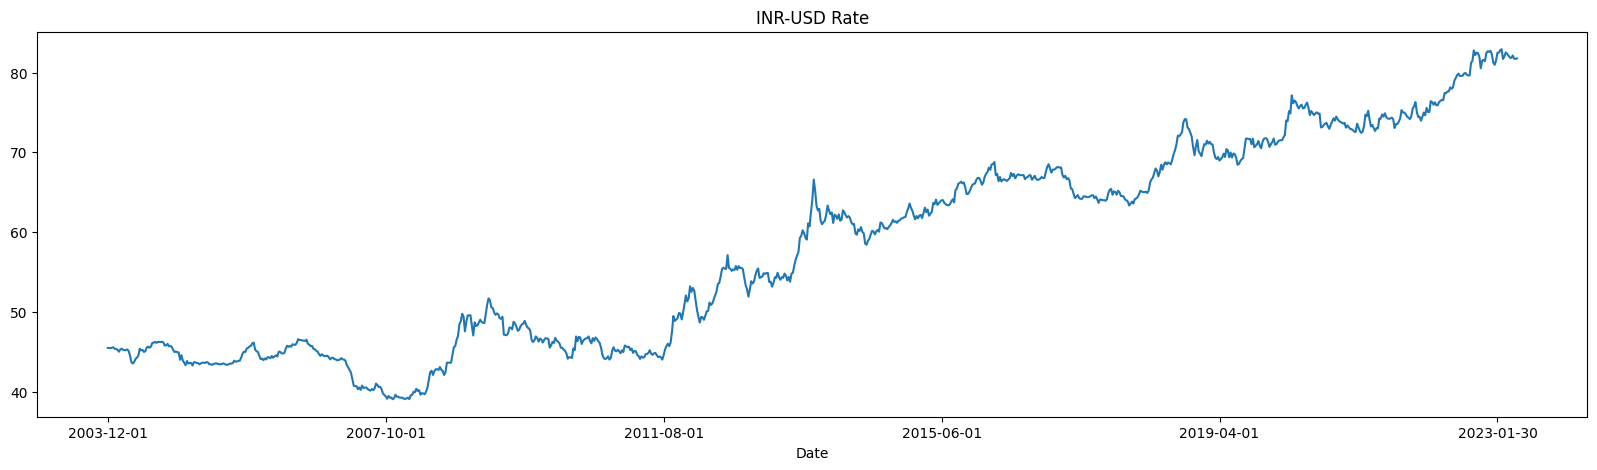

In [76]:
# plot of the original series
df["Adj Close"].plot(figsize=(20,5), title="INR-USD Rate")
plt.show()

In [77]:
def DickeyFuller(x):
    testResult = sts.adfuller(x)
    return f"ADF Test\n-----------------\nTest Statistics: \t{testResult[0]}\np-value: \t\t{testResult[1]}\nH0: \t\t\tSeries is not stationary\nDecision: \t\tNull {'Rejected' if testResult[1]<0.05 else "Accepted"}"

# testing for stationarity of the series
x = sts.adfuller(df["Adj Close"])
print(DickeyFuller(df["Adj Close"])) # not stationary

ADF Test
-----------------
Test Statistics: 	0.22097170947022227
p-value: 		0.9734136060413022
H0: 			Series is not stationary
Decision: 		Null Accepted


### Decomposition

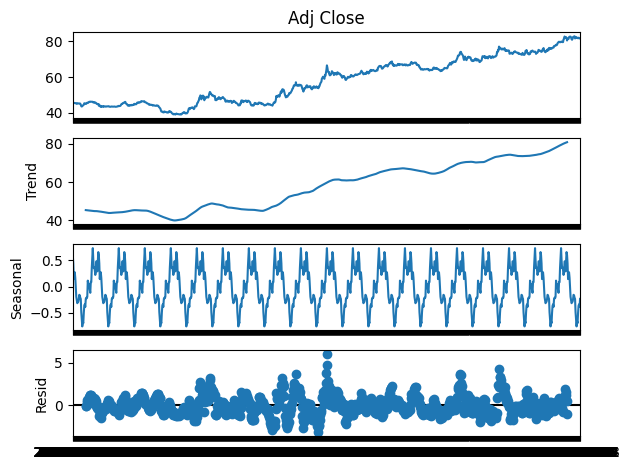

In [78]:
# decomposition of the time series in the trend and seasonal component
s_decom = seasonal_decompose(df["Adj Close"], model="additive", period=52)
s_decom.plot()
plt.show() # Seasonal component is suspected to exist

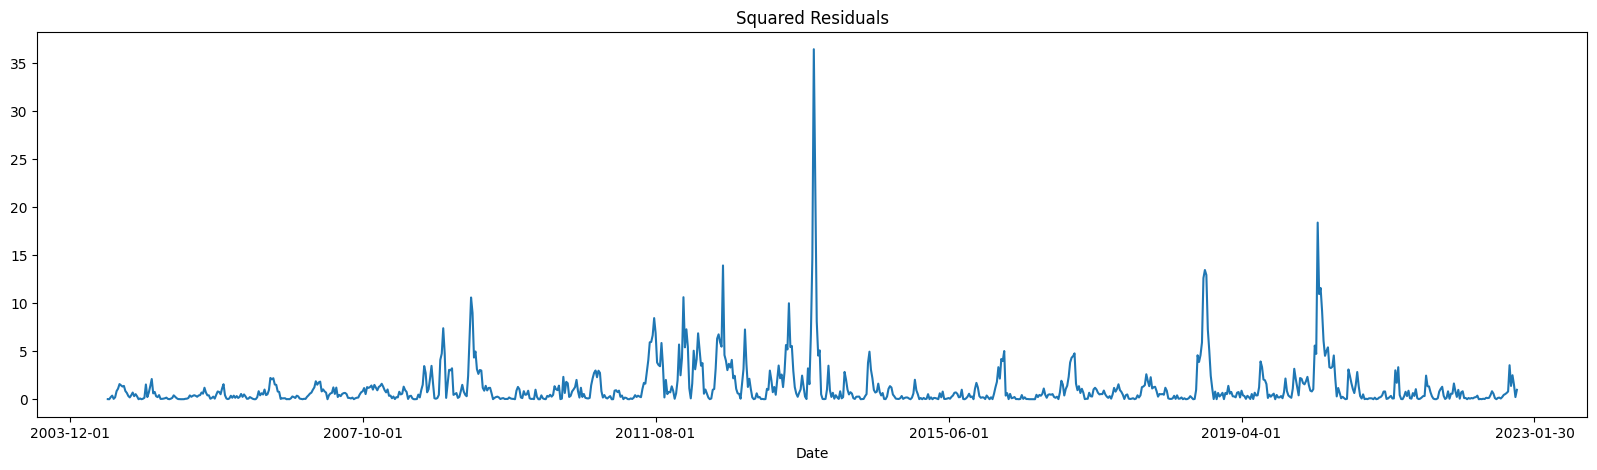

In [79]:
# squared residual plot
(s_decom.resid**2).plot(figsize=(20,5), title="Squared Residuals")
plt.show() # ocassional high spikes of the squared residuals indicates the existence of the volatility in the model

### Train Test Split

In [80]:
# spliting the dataset in to a train and test datset using 80-20 split
size = int(len(df)*0.8)
tr_df = df.iloc[:size]
ts_df = df.iloc[size:]

### SARIMA Order Selection

In [81]:
# fitting a SARIMA(2,1,0)x(2,1,0)[52] model, after applying several trials of other models 
sarima_model = sm.tsa.SARIMAX(tr_df["Adj Close"], order=(2,1,0),
                       seasonal_order=(2,1,0,52))
sarima_fit = sarima_model.fit()
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Adj Close   No. Observations:                  812
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 52)   Log Likelihood                -690.723
Date:                            Sun, 17 Dec 2023   AIC                           1391.446
Time:                                    21:16:52   BIC                           1414.606
Sample:                                12-01-2003   HQIC                          1400.365
                                     - 06-17-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0533      0.028      1.886      0.059      -0.002       0.109
ar.L2          0.0440      0.029      1.510      0.131      -0.013       0.101
ar.S.L52      -0.6029      0.027    -22.108      0.000      -0.656      -0.549
ar.S.L104     -0.2982      0.033     -9.081      0.000      -0.363      -0.234
sigma2         0.3509      0.014     25.039      0.000       0.323       0.378
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.20
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
# predictions by the SARIMA model
pred_mean = sarima_fit.predict(start=ts_df.index[0], end=ts_df.index[-1])

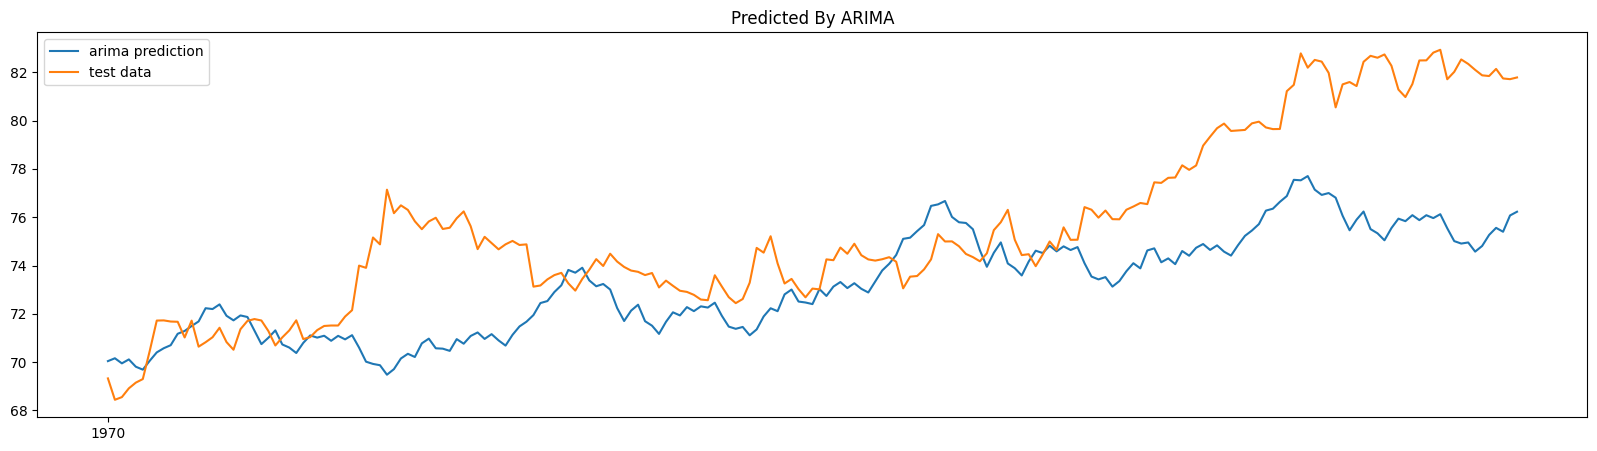

In [83]:
# plot of the predicted SARIMA values on the test dataset
plt.figure(figsize=(20,5))
plt.plot(ts_df.index, pred_mean, label="arima prediction")
plt.plot(ts_df.index, ts_df["Adj Close"], label="test data")
plt.legend()
plt.title("Predicted By ARIMA")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

### Residuals

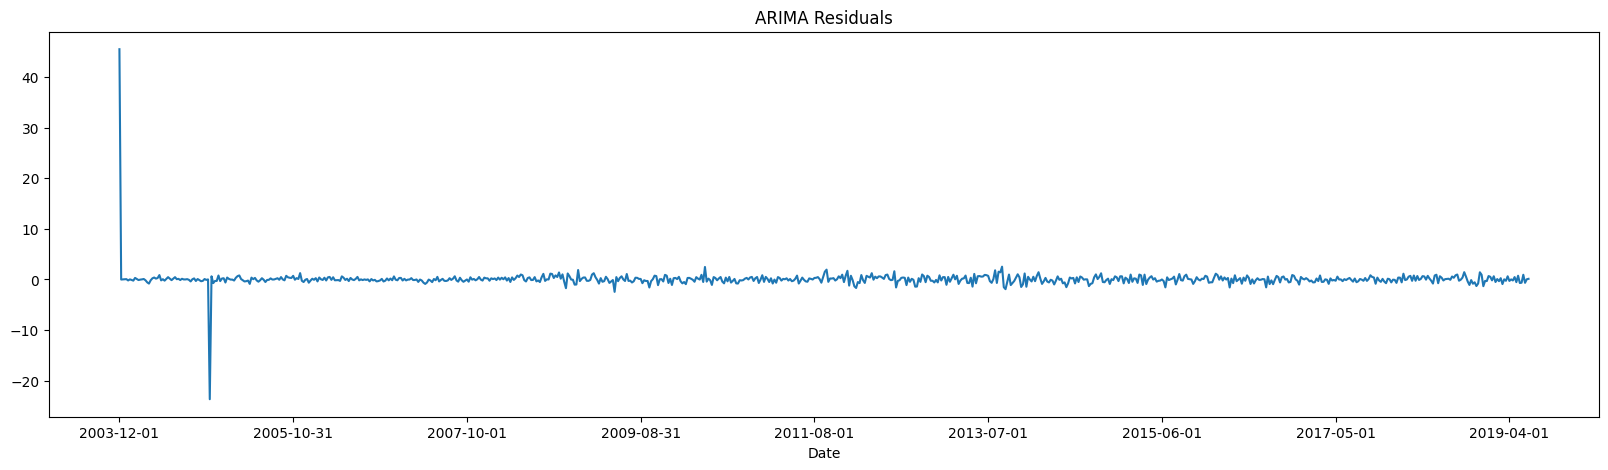

In [84]:
# residuals of SARIMA
sarima_fit.resid.plot(figsize=(20,5), title="ARIMA Residuals") # presence of volatility
plt.show() # spikes indicates the volatility, otherwise it is stationary 

In [85]:
### Dickey Fuller Test for the residuals
print(DickeyFuller(sarima_fit.resid)) # the series is stationary 

ADF Test
-----------------
Test Statistics: 	-53.337585279034485
p-value: 		0.0
H0: 			Series is not stationary
Decision: 		Null Rejected


In [87]:
# fitting GARCH(1,1) model  
garch_model = arch_model(sarima_fit.resid, vol="garch", p=1, q=1)
garch_fit = garch_model.fit(update_freq=0)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 909.5498886079243
            Iterations: 24
            Function evaluations: 136
            Gradient evaluations: 21


In [88]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -909.550
Distribution:                  Normal   AIC:                           1827.10
Method:            Maximum Likelihood   BIC:                           1845.90
                                        No. Observations:                  812
Date:                Sun, Dec 17 2023   Df Residuals:                      811
Time:                        21:17:34   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.6744e-03  2.251e-02      0.163      0.870 [-4.044e-02,4.779e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0211  2.277e-03      9.270  1.863e-20  [1.664e-02,2.557e-02]
alpha[1]   4.7857e-13  6.864e-03  6.973e-11      1.000 [-1.345e-02,1.345e-02]
beta[1]        0.9426  1.179e-02     79.917      0.000      [  0.919,  0.966]
=============================================================================

Covariance estimator: robust
"""

In [89]:
# prediction of garch
pred_garch = garch_fit.forecast(horizon=len(ts_df), align="origin")
pred_vol = np.sqrt(pred_garch.variance.iloc[0])
pred_vol.index = pred_mean.index

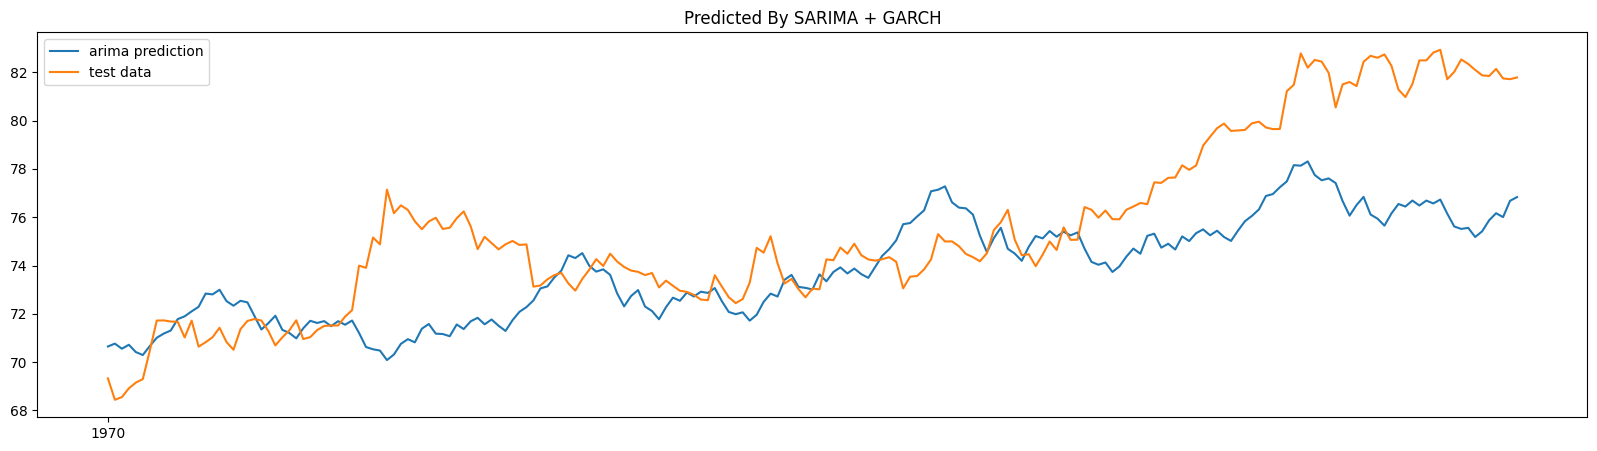

In [90]:
# final prediction (SARIMA + GARCH)
pred = pred_mean + pred_vol
plt.figure(figsize=(20,5))
plt.plot(ts_df.index, pred, label="arima prediction")
plt.plot(ts_df.index, ts_df["Adj Close"], label="test data")
plt.legend()
plt.title("Predicted By SARIMA + GARCH")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

### Analysis of the Residuals

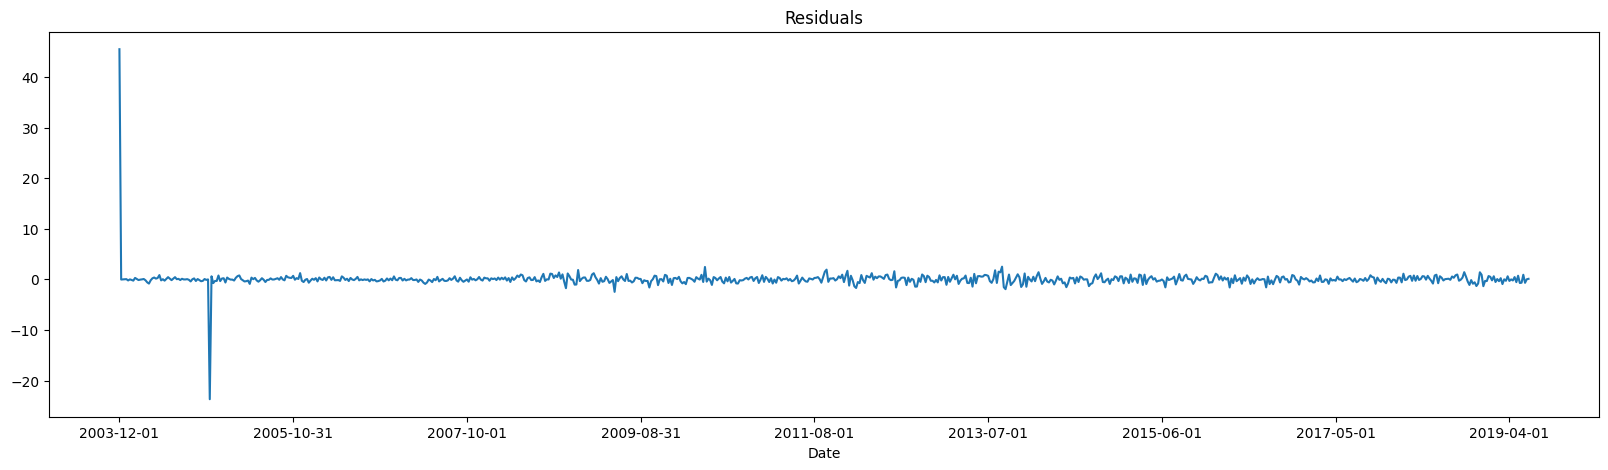

In [91]:
# plot of the final residuals
garch_fit.resid.plot(figsize=(20, 5), title="Residuals")
plt.show()

In [92]:
# Dickey Fuller Test for the residuals
print(DickeyFuller(garch_fit.resid)) # stationary

ADF Test
-----------------
Test Statistics: 	-53.33758527903449
p-value: 		0.0
H0: 			Series is not stationary
Decision: 		Null Rejected


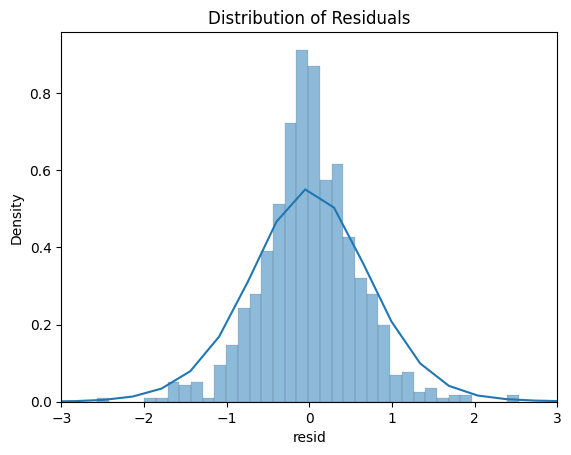

In [93]:
# histogram of the residuals 
sns.histplot(garch_fit.resid, kde=True, stat="density")
plt.title("Distribution of Residuals")
plt.xlim((-3,3))
plt.show() # the residuals seems to be normally distributed

### Model Evaluation

In [94]:
### Accuracy
print(f'''Mean Squared Error: {mean_squared_error(ts_df["Adj Close"], pred)}
Mean Absolute Error: {mean_absolute_error(ts_df["Adj Close"], pred)}
Mean Absolute Percetage Error: {mean_absolute_percentage_error(ts_df["Adj Close"], pred)}''')

Mean Squared Error: 9.480191520746148
Mean Absolute Error: 2.339368072425441
Mean Absolute Percetage Error: 0.030044246706195123


### Final Predicted Plot

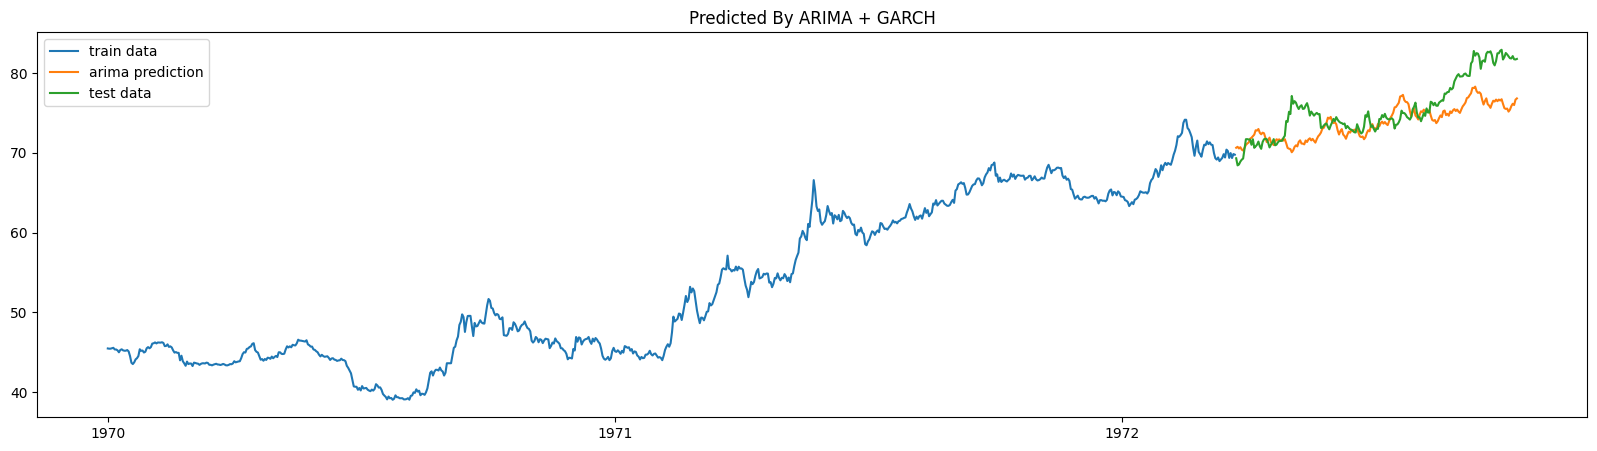

In [95]:
# finally fitted plot
plt.figure(figsize=(20,5))
plt.plot(tr_df.index, tr_df["Adj Close"], label="train data")
plt.plot(ts_df.index, pred, label="arima prediction")
plt.plot(ts_df.index, ts_df["Adj Close"], label="test data")
plt.legend()
plt.title("Predicted By ARIMA + GARCH")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()